In [ ]:
# MLP Model to Predict Next Character in Sequence

In [31]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
#matplotlib inline

In [3]:
# read all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [41]:
# build stoi, itos
chars = sorted(list(set(''.join(words)))) # a to z
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [152]:
# build the training dataset
block_size = 3 # context length. 1 => bigram
X, Y = [], [] # inputs, output (label)

# for w in words[:5]:
for w in words:
    context = [0] * block_size # zero-array with len=block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix], '    training data:', context)
        context = context[1:] + [ix] # crop & append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [154]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [50]:
# lookup table
# cram the 27 characters into a 2 dimensional space
# the paper for example https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf crams 17000 words into a 30 dimensional space
C = torch.randn(27, 2) # 27 rows, 2 columns
C

tensor([[-1.2543,  0.0759],
        [-0.7247,  0.4800],
        [ 1.1438, -0.5919],
        [ 1.2889, -2.5226],
        [-0.0680,  0.2626],
        [ 0.3561,  0.7881],
        [-0.3524,  1.0973],
        [-1.3183, -0.5102],
        [ 0.0869,  1.3165],
        [-0.1901, -2.4250],
        [-0.9328, -0.7188],
        [ 0.4603,  0.5981],
        [ 0.0542,  0.3590],
        [ 1.2589,  1.0805],
        [ 1.1352,  0.5162],
        [ 2.0351,  1.4536],
        [-0.0129,  0.9276],
        [ 0.9687,  0.9717],
        [ 0.8745, -0.3991],
        [-2.3046, -0.4415],
        [-0.2408, -0.5184],
        [ 1.0093, -0.2649],
        [-0.1472,  0.1798],
        [-0.2978, -0.9138],
        [ 0.7083, -0.3547],
        [ 0.1753, -0.2412],
        [ 0.6811, -0.4441]])

In [55]:
# example: indexing into character 'e' in lookup C can either be done by C[5] or, by using one_hot encoding
print(C[5])
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([0.3561, 0.7881])


tensor([0.3561, 0.7881])

In [62]:
# below are equivalent
print(C[[5,6,7,7]])
print(C[torch.tensor([5,6,7,7])])

tensor([[ 0.3561,  0.7881],
        [-0.3524,  1.0973],
        [-1.3183, -0.5102],
        [-1.3183, -0.5102]])
tensor([[ 0.3561,  0.7881],
        [-0.3524,  1.0973],
        [-1.3183, -0.5102],
        [-1.3183, -0.5102]])


In [79]:
# You can also index into C with a 2 dimensional tensor of integers

emb = C[X]
print(C[X].shape) 
# torch.Size([32, 3, 2])
# 32 training data; 3 numbers per training data; 2 dimensions per number
# pytorch indexing is awesome

torch.Size([32, 3, 2])


In [117]:
# hidden layer

# number of inputs is 3x2: Three 2 dimensional embeddings
# number of neurons = 100
W1 = torch.randn(6, 100)
b1 = torch.randn(100)

# what we want is: emb @ W1 + b1
# for that, we need to convert emb from 32x3x2 to 32x6
# some ways to do this:

# 1. by concatenation -
print(emb[:, 0, :].shape)
print(torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape)
# simplifying it, and generalizing it.
# unbind splits along a specific dimension.
print(torch.cat(torch.unbind(emb, 1), 1).shape)

# 2. by changing views -
print(emb.view(32, 6).shape)
# Extremely fast, dimensional changes, no change to storage
# confirm equivalent via:
# (emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1))

# using -1 will make pytorch derive the dimension
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
# what is happening here ?
# 6 inputs to hidden layer of 100 neurons
# multiplying it and adding biases, we get activations.
# except, this is being done for all training data at the same time.
# emb.view(-1, 6) is 32x6; W1 is 6x100 so result is 32x100 + b1, which is [100]
# 32x100 + 100 === 32x100 + 1x100 (broadcasting rules)
# so the bias vector is added to each of the 32 rows

torch.Size([32, 2])
torch.Size([32, 6])
torch.Size([32, 6])
torch.Size([32, 6])


In [119]:
# Final layer (output)
# 27 outputs

W2 = torch.randn(100, 27)
b2 = torch.randn(27)

In [120]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [124]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims = True)
print(prob.shape)

torch.Size([32, 27])


In [130]:
# for each row, we want to pluck out probability assigned to character in Y (label data), since we want to maximize that
print(prob[torch.arange(32), Y])

# loss function: -nll
loss = -prob[torch.arange(32), Y].log().mean()
print(loss) # we want to minimize this

tensor([9.0918e-13, 2.7426e-12, 3.5438e-09, 2.9452e-11, 4.8875e-09, 3.2843e-07,
        9.8846e-11, 1.5821e-06, 6.9024e-05, 1.1974e-06, 2.9102e-09, 1.0895e-11,
        3.1192e-05, 1.1615e-11, 3.9840e-11, 8.8743e-03, 2.8277e-03, 3.8915e-03,
        1.8193e-06, 6.0760e-01, 6.1072e-09, 1.0393e-07, 1.7618e-04, 3.2526e-11,
        2.0817e-01, 1.3766e-06, 6.9147e-06, 1.6680e-10, 9.7529e-01, 2.2009e-03,
        5.2569e-06, 2.8097e-12])
tensor(15.2541)


# Tying everything above together

In [131]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [247]:
# 6x100x27 neural net
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [156]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [140]:
# forward pass
emb = C[X] # 32x3x2
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # 32x100
logits = h @ W2 + b2 # 32x27

# loss function
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = -prob[torch.arange(32), Y].log().mean()
print(loss)

tensor(17.7697)


In [141]:
# Cool part: The entire loss function is standardized into F.cross_entropy
# which is essentially what we should use for classification problems, and is more efficient
print(F.cross_entropy(logits, Y))

tensor(17.7697)


In [161]:
for _ in range(10):
    # forward pass
    emb = C[X] # 228146x3x2
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # 228146x100
    logits = h @ W2 + b2 # 228146x27
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    for p in parameters:
        p.data += -0.1 * p.grad



8.329230308532715
8.144328117370605
7.966794967651367
7.796453475952148
7.6331892013549805
7.4769110679626465
7.3275251388549805
7.18488883972168
7.048794746398926
6.918956279754639


# above takes too long since we are running forward and backward pass on a dataset of size 228146. In reality, training is done in batches.

In [177]:
# below generates numbers between zero and 5, and generates 32 of them
torch.randint(0, 5, (32,)) 

tensor([4, 4, 4, 2, 1, 3, 4, 2, 2, 4, 4, 3, 4, 4, 2, 3, 2, 0, 4, 1, 2, 3, 1, 4,
        0, 1, 2, 3, 1, 2, 2, 4])

In [194]:
# Using mini batch

for _ in range(100):
    # minibatch construct with size = 32
    # use below ix to index into X and Y
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]] # 32x3x2
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # 32x100
    logits = h @ W2 + b2 # 32x27
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    for p in parameters:
        p.data += -0.1 * p.grad

20.04845428466797
30.315080642700195
46.94538497924805
33.31100082397461
58.64977264404297
73.1107406616211
79.67898559570312
89.60714721679688
72.86589813232422
57.464996337890625
55.16591262817383
71.26180267333984
52.350852966308594
50.68392562866211
69.63793182373047
47.982295989990234
57.372291564941406
92.12295532226562
76.15151977539062
89.41002655029297
125.60802459716797
102.44636535644531
86.48458862304688
105.43888854980469
63.032203674316406
65.77123260498047
59.73176956176758
59.29250717163086
86.7674789428711
72.65473937988281
99.30374908447266
83.57038116455078
66.83503723144531
83.01271057128906
105.08273315429688
42.41501998901367
97.78849029541016
98.2080078125
53.23658752441406
65.515869140625
86.58196258544922
64.1628646850586
67.46561431884766
67.76799774169922
52.951847076416016
75.42171478271484
86.67947387695312
71.90614318847656
117.56005859375
85.37887573242188
94.45606994628906
79.40536499023438
85.07559204101562
58.703033447265625
57.9099235534668
47.7490997

# Above is way faster, at the cost of not choosing the perfect gradient.
# What this shows is that it's much better to take more steps in approximate gradient than slow steps with accurate gradients

In [184]:
# overall loss
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # 32x100
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.4816, grad_fn=<NllLossBackward0>)

# Tip: How to determine a reasonable learning rate ?
# Print loss at each step, and see if it's decreasing reasonably.
# Low learning rate (0.001) => decreases are barely noticeable every 100 iterations
# High learning rate (1) => unstable
# Too high learning rate (10) => too unstable, loss increases

# So, we know we want something in between 0.001 and 1, we can plot loss change wrt learning rate like below

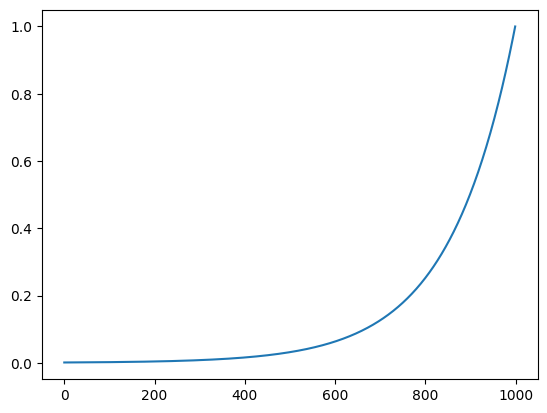

In [213]:
# creating learning rate candidates between -0.001 and -1, with exponential decay
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs
plt.plot(lrs)

In [218]:
# using dynamic learning rate, to figure out impact of learning rate
lri = []
lossi = []
for i in range(1000):
    # minibatch construct with size = 32
    # use below ix to index into X and Y
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]] # 32x3x2
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # 32x100
    logits = h @ W2 + b2 # 32x27
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    lri.append(lr.item())
    lossi.append(loss.item())

8.848243713378906
10.254158020019531
10.970457077026367
8.622817039489746
9.807044982910156
8.237765312194824
9.310035705566406
8.068034172058105
9.60606861114502
9.246604919433594
9.432703018188477
8.118677139282227
9.028709411621094
9.113194465637207
7.6128106117248535
8.426941871643066
9.151798248291016
11.377342224121094
8.625144004821777
8.349547386169434
7.722926616668701
9.504220962524414
10.02465534210205
9.932746887207031
7.549596309661865
10.880911827087402
8.646660804748535
9.7676420211792
9.211591720581055
9.36791706085205
6.829631328582764
7.858790874481201
9.478151321411133
8.975810050964355
8.654661178588867
7.322317123413086
8.868688583374023
8.264164924621582
9.15020751953125
6.970569133758545
7.134612083435059
9.019259452819824
9.773761749267578
10.47582721710205
10.338351249694824
8.474041938781738
7.866513729095459
7.522794723510742
9.387890815734863
10.513896942138672
8.497529029846191
10.194086074829102
7.060439109802246
8.554845809936523
8.590127944946289
8.82328

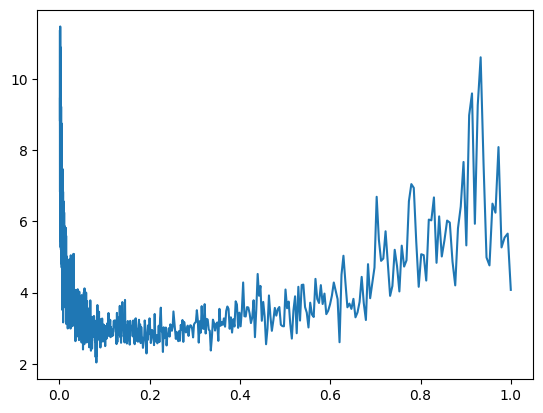

In [219]:
plt.plot(lri, lossi)

# you can see below that there was higher instability
# around 0.1 is actually a good learning rate, so we now have some confidence

# In practice, you'd train for a while with 0.1, then decay by a factor of 10, and do a few more steps for some improvements

In [236]:
for _ in range(10000):
    # minibatch construct with size = 32
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]] # 32x3x2
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # 32x100
    logits = h @ W2 + b2 # 32x27
    loss = F.cross_entropy(logits, Y[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.001
    for p in parameters:
        p.data += -lr * p.grad

In [237]:
# overall loss
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # 228146x100
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.3052, grad_fn=<NllLossBackward0>)

# We have a better loss than bigram model 2.45, this is at 2.30

# What's important to note here is that, we have a NN with around ~3k parameters. The more parameters we add, say 100,000 or millions, the model becomes more and more capable of over-fitting the training set, but essentially it will end up memorizing the training set => sampling from it will more likely just give the training data, and the loss on data not part of the training set can end up being quite high.

# The standard approach to fix over-fitting is to split up the model into 3 parts -

## Training Split (80%): This is used to optimize parameters (gradient descent)
## Dev / Validation Split (10%): Train the hyperparameters, for example: size of hidden layer, size of embeddings, strength of regularization, ... essentially settings of NN
## Test Split (10%): Used to evaluate performance of model at the end. We want to evaluate loss on test split very sparingly, so that we don't risk over-fitting the model to test data

In [307]:
# build the dataset

def build_dataset(words):
    block_size = 3
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

print(n1, n2-n1, len(words) - n2)

25626 3203 3204


In [319]:
lossi, stepi = [], []

# run five times with 0.1 and with 0.05 two times
for i in range(30000):
    # minibatch construct with size = 32
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]] # 32x3x2
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # 32x100
    logits = h @ W2 + b2 # 32x27
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.05
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    lossi.append(loss.item())
    stepi.append(i)

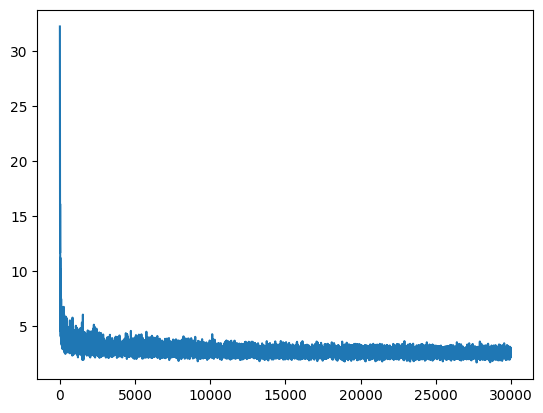

In [309]:
plt.plot(stepi, lossi)

In [320]:
# overall loss
def overall_loss(X, Y):
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    return F.cross_entropy(logits, Y)    

print(overall_loss(Xtr, Ytr))
print(overall_loss(Xdev, Ydev))

# we see the loss is similar across training and dev data
# so, we can be confident it's not over fitting

# if dev loss is roughly equal to training loss, we can assume the model is under-fitting. which typically means that the network is small, we'll increase the network size below

tensor(2.2979, grad_fn=<NllLossBackward0>)
tensor(2.3100, grad_fn=<NllLossBackward0>)


In [306]:
# 6x300x27 neural net
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
    
print(sum(p.nelement() for p in parameters))

10281


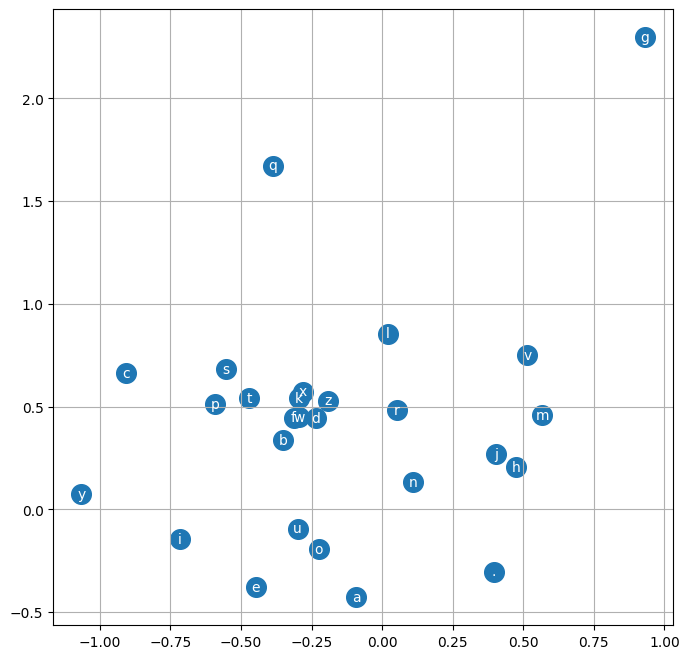

In [321]:
# visualizing the 2 dimension vectors
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

# interesting to see that aeiou are clustered
# Things closer together are similar

In [ ]:
# at this point, since the increase in NN size hasn't significantly improved fitting, the constraint can be the embedding vectors. Let's make them bigger. Say, 10 dimensional embeddings.

In [337]:
# 30x200x27 neural net
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
    
print(sum(p.nelement() for p in parameters))

11897


In [338]:
lossi, stepi = [], []

In [339]:
for i in range(200000):
    # minibatch construct with size = 32
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]] # 32x3x10
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2 # 32x27
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    # we use log loss for tracking since log squashes the hockey-stick appearance of the previous graph, making it look nicer
    lossi.append(loss.log10().item())
    stepi.append(i)

In [340]:
def overall_loss(X, Y):
    emb = C[X]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    return F.cross_entropy(logits, Y)    

print(overall_loss(Xtr, Ytr))
print(overall_loss(Xdev, Ydev))

tensor(2.1195, grad_fn=<NllLossBackward0>)
tensor(2.1543, grad_fn=<NllLossBackward0>)


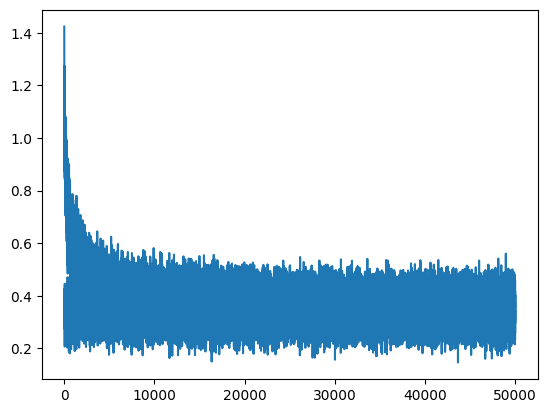

In [334]:
plt.plot(stepi, lossi)

In [456]:
# sampling from the model

g = torch.Generator().manual_seed(2147483647)

for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        # until generating ., embed
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
        logits = h @ W2 + b2
        
        # counts = logits.exp()
        # prob = counts / counts.sum(1, keepdims=True)
        # simpler to use softmax 
        prob = F.softmax(logits, dim=1)
        
        next = torch.multinomial(prob, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[next])
        context = context[1:] + [next]
        if next == 0: break
    print(''.join(out))
        
    

celie.
coullus.
ileighannell.
imitta.
nollyan.
kaida.
samiyah.
javariiotap.
mola.
danio.
